# Preprocessing and Initial Model #

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Normal vs Pneumonia X-rays ##

In [158]:
# Directory Paths
train_normal = 'CellData/chest_xray/train/NORMAL'
train_sick = 'CellData/chest_xray/train/PNEUMONIA'
test_normal = 'CellData/chest_xray/test/NORMAL'
test_sick = 'CellData/chest_xray/test/PNEUMONIA'

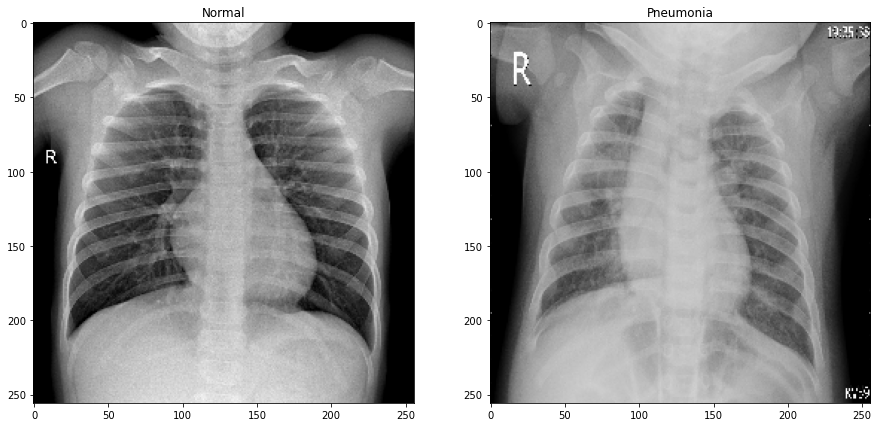

In [137]:
# Loading image:
fig, ax = plt.subplots(nrows = 1, ncols=2,figsize=(15,15))
img1 = load_img(f'{train_normal}/NORMAL-28501-0001.jpeg', target_size=(256,256))
ax[0].imshow(img1)
ax[0].set_title('Normal');
img2 = load_img(f'{train_sick}/BACTERIA-52163-0002.jpeg', target_size=(256,256))
ax[1].imshow(img2)
ax[1].set_title('Pneumonia');

## Creating the Dataset ##

In [106]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (500 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train (500 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=2496)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [117]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(2496, 256, 256, 3)
(2496, 2)
(624, 256, 256, 3)
(624, 2)


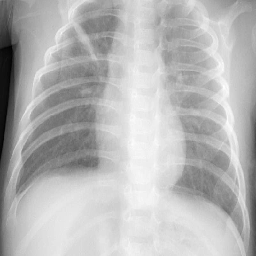

In [107]:
array_to_img(train_images[132])

In [110]:
train_labels[132]

array([0., 1.], dtype=float32)

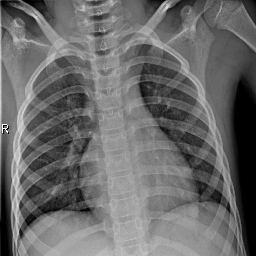

In [111]:
array_to_img(train_images[355])

In [112]:
train_labels[355]

array([1., 0.], dtype=float32)

In [113]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Preprocessing ##

### Fixing the labels ###

In [210]:
# fix the labels for the images so that normal=0 and pneumonia=1
y_model = train_labels.T[[1]]
y_test = test_labels.T[[1]]

In [211]:
# counts for each class
print('Train Class Counts:', np.unique(y_model, return_counts=True))
print('Test Class Counts:', np.unique(y_test, return_counts=True))

Train Class Counts: (array([0., 1.], dtype=float32), array([ 649, 1847]))
Test Class Counts: (array([0., 1.], dtype=float32), array([234, 390]))


In [212]:
y_model = y_model.T
y_test = y_test.T

### Reshape and standardize images###

In [213]:
# reshape the images
train_img_unrow = train_images.reshape(2496, -1)
test_img_unrow = test_images.reshape(624, -1)

In [214]:
train_img_unrow.shape, test_img_unrow.shape

((2496, 196608), (624, 196608))

In [215]:
# standardize data
X_model = train_img_unrow/255
X_test = test_img_unrow/255

In [216]:
X_model.shape

(2496, 196608)

## Building the model ##

In [245]:
# split model set into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=765)

### Model 1 ###

In [264]:
# function for visualizing loss and accuracy across epochs for training and validation set
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [265]:
model_1 = Sequential()
model_1.add(layers.Dense(128, activation='tanh', input_shape=(196608,)))
model_1.add(layers.Dense(64, activation='tanh'))
model_1.add(layers.Dense(32, activation='tanh'))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [266]:
model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [267]:
results_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 7s 225ms/step - loss: 0.6094 - accuracy: 0.7455 - val_loss: 0.5864 - val_accuracy: 0.7240
Epoch 2/10
32/32 [==============================] - 7s 233ms/step - loss: 0.5566 - accuracy: 0.7440 - val_loss: 0.5917 - val_accuracy: 0.7240
Epoch 3/10
32/32 [==============================] - 7s 224ms/step - loss: 0.5549 - accuracy: 0.7440 - val_loss: 0.6135 - val_accuracy: 0.7240
Epoch 4/10
32/32 [==============================] - 7s 230ms/step - loss: 0.5447 - accuracy: 0.7440 - val_loss: 0.5911 - val_accuracy: 0.7240
Epoch 5/10
32/32 [==============================] - 7s 232ms/step - loss: 0.5286 - accuracy: 0.7440 - val_loss: 0.5369 - val_accuracy: 0.7240
Epoch 6/10
32/32 [==============================] - 7s 226ms/step - loss: 0.5251 - accuracy: 0.7440 - val_loss: 0.5469 - val_accuracy: 0.7240
Epoch 7/10
32/32 [==============================] - 8s 241ms/step - loss: 0.5165 - accuracy: 0.7440 - val_loss: 0.5737 - val_accuracy: 0.7240
Epoch 

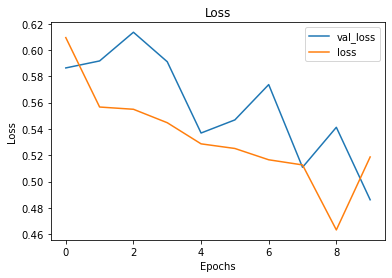

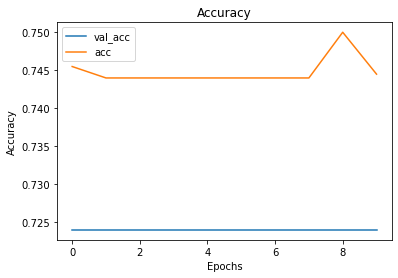

In [268]:
# change in loss and accuracy for training and validation set per epoch
visualize_training_results(results_1)

In [269]:
# evaluate training and test sets
results_train = model_1.evaluate(X_train, y_train)
results_test = model_1.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 1s 41ms/step - loss: 0.5951 - accuracy: 0.6250
[0.46172794699668884, 0.7439879775047302] [0.5950748324394226, 0.625]


### Model 2 ###

In [271]:
model_2 = Sequential()
model_2.add(layers.Dense(128, activation='relu', input_shape=(196608,)))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [272]:
model_2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [273]:
results_2 = model_2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/10
32/32 [==============================] - 8s 256ms/step - loss: 1.4357 - accuracy: 0.6994 - val_loss: 0.5707 - val_accuracy: 0.7240
Epoch 2/10
32/32 [==============================] - 8s 248ms/step - loss: 0.5407 - accuracy: 0.7290 - val_loss: 0.5320 - val_accuracy: 0.7240
Epoch 3/10
32/32 [==============================] - 7s 231ms/step - loss: 0.4848 - accuracy: 0.7535 - val_loss: 0.6945 - val_accuracy: 0.7240
Epoch 4/10
32/32 [==============================] - 8s 247ms/step - loss: 0.4446 - accuracy: 0.8096 - val_loss: 0.3748 - val_accuracy: 0.9000
Epoch 5/10
32/32 [==============================] - 8s 237ms/step - loss: 0.4246 - accuracy: 0.8181 - val_loss: 0.8451 - val_accuracy: 0.7240
Epoch 6/10
32/32 [==============================] - 8s 245ms/step - loss: 0.3775 - accuracy: 0.8517 - val_loss: 0.5211 - val_accuracy: 0.7160
Epoch 7/10
32/32 [==============================] - 6s 201ms/step - loss: 0.3880 - accuracy: 0.8417 - val_loss: 0.4448 - val_accuracy: 0.9060
Epoch 

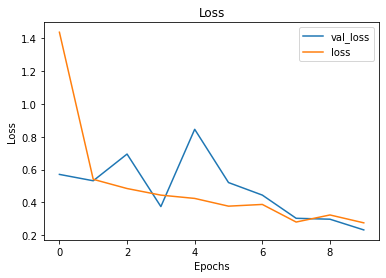

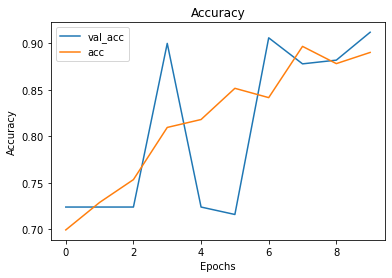

In [274]:
visualize_training_results(results_2)

In [275]:
results_train = model_2.evaluate(X_train, y_train)
results_test = model_2.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 1s 39ms/step - loss: 0.3750 - accuracy: 0.8349
[0.1835871934890747, 0.9338677525520325] [0.37502676248550415, 0.8349359035491943]


### Model 3 ###

In [277]:
model_3 = Sequential()
model_3.add(layers.Dense(256, activation='relu', input_shape=(196608,)))
model_3.add(layers.Dense(128, activation='relu'))
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(32, activation='relu'))
model_3.add(layers.Dense(16, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [279]:
model_3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [280]:
results_3 = model_3.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/10
32/32 [==============================] - 14s 448ms/step - loss: 0.5833 - accuracy: 0.6954 - val_loss: 0.5571 - val_accuracy: 0.7240
Epoch 2/10
32/32 [==============================] - 16s 488ms/step - loss: 0.5259 - accuracy: 0.7440 - val_loss: 0.6501 - val_accuracy: 0.8120
Epoch 3/10
32/32 [==============================] - 14s 432ms/step - loss: 0.4962 - accuracy: 0.7756 - val_loss: 0.6573 - val_accuracy: 0.6160
Epoch 4/10
32/32 [==============================] - 13s 403ms/step - loss: 0.5039 - accuracy: 0.7385 - val_loss: 0.5771 - val_accuracy: 0.6820
Epoch 5/10
32/32 [==============================] - 12s 375ms/step - loss: 0.4321 - accuracy: 0.8136 - val_loss: 0.3231 - val_accuracy: 0.8920
Epoch 6/10
32/32 [==============================] - 12s 376ms/step - loss: 0.3980 - accuracy: 0.8181 - val_loss: 1.0950 - val_accuracy: 0.2760
Epoch 7/10
32/32 [==============================] - 13s 395ms/step - loss: 0.4808 - accuracy: 0.7610 - val_loss: 0.5366 - val_accuracy: 0.7280

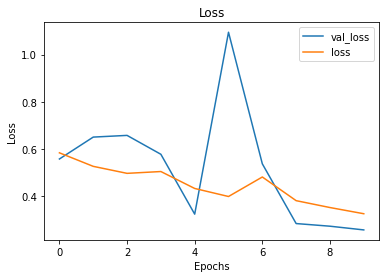

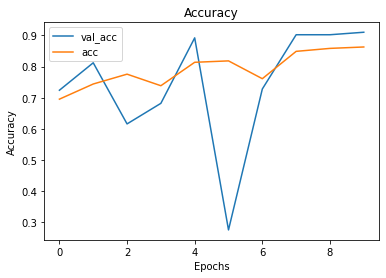

In [281]:
visualize_training_results(results_3)

In [282]:
results_train = model_3.evaluate(X_train, y_train)
results_test = model_3.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 1s 70ms/step - loss: 0.3881 - accuracy: 0.8237
[0.21156133711338043, 0.9283567070960999] [0.3880821466445923, 0.8237179517745972]
